# Fun with statistics & algorithms

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time

from multiprocessing import Pool, cpu_count

## 1. Simulated annealing

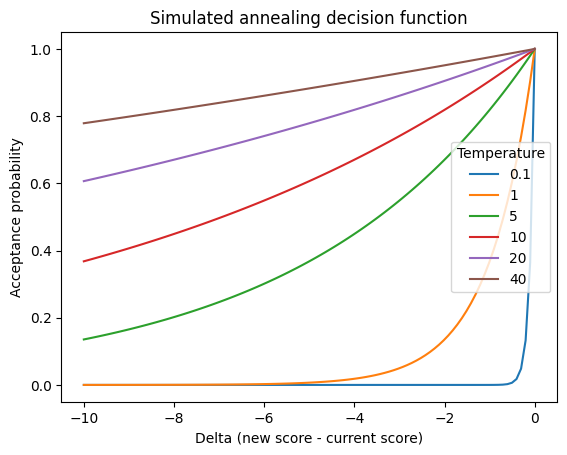

In [2]:
def decision_function(delta, temp):
    return np.exp(delta / temp)

deltas = np.linspace(-10, 0, 100)
temps = [0.1, 1, 5, 10, 20, 40]

plt.title('Simulated annealing decision function')

for temp in temps:
    plt.plot(deltas, decision_function(deltas, temp), label=temp)
    plt.xlabel('Delta (new score - current score)')
    plt.ylabel('Acceptance probability')

plt.legend(title='Temperature')
plt.show()

## 2. Hill climbing

### 2.1. Function definitions

#### 2.1.1. Hill climbing functions

In [3]:
def perturb_vectors(*arrays, step_size):
    '''Randomly perturb a single value in one of the input arrays.
    
    Ensures all values remain strictly positive (> 0) after perturbation.
    Works with any number of n-dimensional arrays.
    
    Args:
        *arrays: Variable number of numpy arrays to potentially perturb
        step_size: maximum perturbation amount
        
    Returns:
        Tuple of perturbed arrays in the same order as input
    '''
    
    # Create copies to avoid modifying originals
    new_arrays = [arr.copy() for arr in arrays]
    
    # Randomly select which array to perturb
    array_idx = np.random.randint(0, len(arrays))
    
    # Get the selected array
    selected_array = new_arrays[array_idx]
    
    # Flatten the array to select a random element
    flat_array = selected_array.flatten()
    element_idx = np.random.randint(0, len(flat_array))
    
    # Perturb the selected value and ensure it stays strictly positive
    original_value = flat_array[element_idx]
    perturbation = np.random.uniform(-step_size, step_size)
    new_value = original_value + perturbation
    
    # If the new value would be <= 0, try again with a positive-only perturbation
    if new_value <= 0:
        perturbation = np.random.uniform(0, step_size)
        new_value = original_value + perturbation
    
    flat_array[element_idx] = new_value
    
    # Reshape back to original shape
    new_arrays[array_idx] = flat_array.reshape(selected_array.shape)
    
    return tuple(new_arrays)


def calculate_correlation_objective(x, y, objective_func):
    '''Calculate objective function using the specified objective.
    
    Args:
        x: numpy array or pandas Series
        y: numpy array or pandas Series
        objective_func: function that calculates the objective
        
    Returns:
        Tuple of (pearson_corr, spearman_corr, objective_value)
    '''
    return objective_func(x, y)


def hill_climb(
        x, y,
        max_time,
        step_size, 
        temperature,
        cooling_rate,
        objective_func
):
    '''Performs hill climbing with optional simulated annealing to maximize 
    the specified objective function.
    
    Args:
        x: numpy array of x values
        y: numpy array of y values
        objective_func: objective function to optimize
        output_file: path to save intermediate results
        max_time: maximum time in minutes
        step_size: maximum perturbation amount
        steps: optional pre-existing steps dictionary
        temperature: initial temperature for simulated annealing 
        cooling_rate: rate at which temperature decreases
    '''

    steps = {
        'Step': [],
        'Pearson coefficient': [],
        'Spearman coefficient': [],
        'Objective value': [],
        'Best_x': [],
        'Best_y': []
    }

    best_x = x.copy()
    best_y = y.copy()
    current_x = x.copy()
    current_y = y.copy()
    
    pearson_corr, spearman_corr, best_objective = calculate_correlation_objective(x, y, objective_func)
    current_objective = best_objective
    step = 0
    temp = temperature

    start_time = time.time()

    while time.time() - start_time < max_time * 60:

        step += 1
    
        # Perturb the vectors
        new_x, new_y = perturb_vectors(current_x, current_y, step_size=step_size)
        pearson_corr, spearman_corr, new_objective = calculate_correlation_objective(new_x, new_y, objective_func)
        
        # Decide whether to accept the new solution
        if temperature > 0:

            # Simulated annealing: accept worse solutions with probability
            delta = new_objective - current_objective
            
            if delta >= 0:
                # Better or equivalent solution - always accept
                accept = True

            else:
                # Worse solution - accept with probability based on temperature
                # Use max to prevent temp from getting too small and causing overflow
                accept_prob = np.exp(delta / max(temp, 1e-10))
                accept = np.random.random() < accept_prob

            if accept:
                current_x = new_x
                current_y = new_y
                current_objective = new_objective
                
                # Update best if current is better
                if current_objective > best_objective:
                    best_x = current_x.copy()
                    best_y = current_y.copy()
                    best_objective = current_objective
                    
                    steps['Step'].append(step)
                    steps['Pearson coefficient'].append(pearson_corr)
                    steps['Spearman coefficient'].append(spearman_corr)
                    steps['Objective value'].append(best_objective)
                    steps['Best_x'].append(best_x.copy())
                    steps['Best_y'].append(best_y.copy())
            
            # Cool down
            temp *= cooling_rate

        else:
            # Standard hill climbing: only accept improvements
            if new_objective > best_objective:
                best_x = new_x
                best_y = new_y
                best_objective = new_objective
                current_x = new_x
                current_y = new_y
                current_objective = new_objective

                steps['Step'].append(step)
                steps['Pearson coefficient'].append(pearson_corr)
                steps['Spearman coefficient'].append(spearman_corr)
                steps['Objective value'].append(best_objective)
                steps['Best_x'].append(best_x.copy())
                steps['Best_y'].append(best_y.copy())

    return best_x, best_y, pd.DataFrame(steps)


def hill_climb_wrapper(args):
    x, y, max_time, step_size, temperature, cooling_rate, objective_func = args

    return hill_climb(
        x, y,
        max_time,
        step_size, 
        temperature=temperature,
        cooling_rate=cooling_rate,
        objective_func=objective_func
    )


def hill_climb_parallel(
        x, y,
        objective_func,
        max_time=3,
        step_size=0.1, 
        replicates=4,
        initial_noise=0.0,
        temperature=0.0,
        cooling_rate=0.995, 
):
    '''Run hill climbing in parallel with multiple replicates of a single input distribution.
    
    Args:
        x: numpy array of x values
        y: numpy array of y values
        max_time: Maximum time in minutes for each hill climb run (default: 3)
        step_size: Step size for perturbations (default: 0.1)
        replicates: Number of parallel replicates to run (default: 4)
        initial_noise: Standard deviation of Gaussian noise to add to initial vectors for diversity (default: 0.0)
        temperature: Initial temperature for simulated annealing (default: 0.0, disabled)
        cooling_rate: Rate at which temperature decreases (default: 0.995)
        objective_func: Objective function to optimize (default: objective_spearman_large_pearson_small)
        
    Returns:
        List of tuples, where each tuple is (best_x, best_y, steps_df) for each replicate
    '''
    
    # Create replicate inputs with optional noise
    replicate_inputs = []
    
    for _ in range(replicates):
        # Create copies for each replicate
        new_x = x.copy()
        new_y = y.copy()
        
        # Add random noise for diversity across replicates
        if initial_noise > 0:
            new_x += np.random.normal(0, initial_noise, len(new_x))
            new_y += np.random.normal(0, initial_noise, len(new_y))
        
        replicate_inputs.append((new_x, new_y))
    
    # Check if we have enough CPU resources
    available_cpus = cpu_count()
    
    if replicates > available_cpus:
        raise ValueError(f"Number of replicates ({replicates}) must be less than or equal to CPU count ({available_cpus}). "
                        f"Reduce the number of replicates or use a machine with more CPUs.")
    
    # Prepare arguments for each hill_climb call
    args_list = [
        (x, y, max_time, step_size, temperature, cooling_rate, objective_func)
        for (x, y) in replicate_inputs
    ]
    
    # Run in parallel
    with Pool(processes=replicates) as pool:
        results = pool.map(hill_climb_wrapper, args_list)
    
    return results

#### 2.1.2. Objective functions

In [4]:
def objective_spearman_large_pearson_small(x, y):
    '''Objective: Small Pearson correlation + Large Spearman correlation.
    
    Maximizes: |Spearman| - |Pearson|
    Encourages small Pearson (close to 0) and large Spearman (close to +/-1).
    '''
    pearson_corr = pd.Series(x).corr(pd.Series(y), method='pearson')
    spearman_corr = pd.Series(x).corr(pd.Series(y), method='spearman')
    objective = abs(spearman_corr) - abs(pearson_corr)
    return pearson_corr, spearman_corr, objective


def objective_max_absolute_difference(x, y):
    '''Objective: Maximum absolute difference between Pearson and Spearman.
    
    Maximizes: |Spearman - Pearson|
    Encourages the largest possible difference between the two correlations.
    '''
    pearson_corr = pd.Series(x).corr(pd.Series(y), method='pearson')
    spearman_corr = pd.Series(x).corr(pd.Series(y), method='spearman')
    objective = abs(spearman_corr - pearson_corr)
    return pearson_corr, spearman_corr, objective


def objective_pearson_large_spearman_small(x, y):
    '''Objective: Large Pearson correlation + Small Spearman correlation.
    
    Maximizes: |Pearson| - |Spearman|
    Encourages large Pearson (close to +/-1) and small Spearman (close to 0).
    '''
    pearson_corr = pd.Series(x).corr(pd.Series(y), method='pearson')
    spearman_corr = pd.Series(x).corr(pd.Series(y), method='spearman')
    objective = abs(pearson_corr) - abs(spearman_corr)
    return pearson_corr, spearman_corr, objective

### 2.2. Input distributions

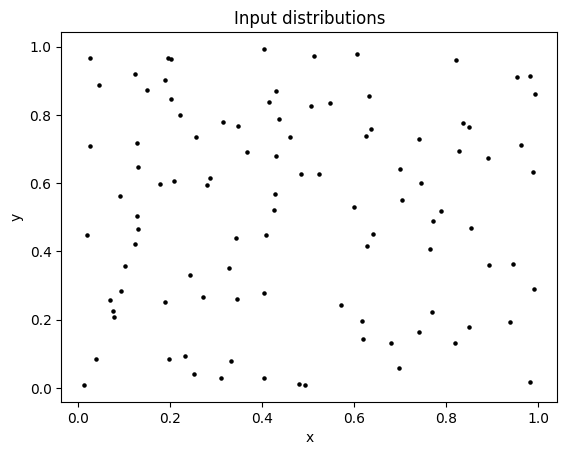

In [5]:
# Create input distribution
# Set the size of input vectors
n = 100

# Exponential relationship with higher noise (shifted to positive)
x = np.random.rand(n)
y = np.random.rand(n)

plt.title('Input distributions')
plt.scatter(x, y, s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 2.3. Run parameters

In [6]:
# Set hyperparameters as variables for easy modification and saving
max_time = 1
step_size = 0.1
replicates = 1
temperature = 40.0
initial_noise = 0.1
cooling_rate = 0.9999999
objective_func = objective_spearman_large_pearson_small

# Create hyperparameters dictionary
hyperparameters = {
    'max_time': max_time,
    'step_size': step_size,
    'replicates': replicates,
    'initial_noise': initial_noise,
    'temperature': temperature,
    'cooling_rate': cooling_rate,
    'objective_function': objective_func.__name__,
    'input_size': len(x)
}

### 2.4. Hill climbing run

In [7]:
# Run in parallel with specified hyperparameters
print(f"Running hill climbing with objective: {objective_func.__name__}")
print(f"Running {replicates} replicates in parallel")

results = hill_climb_parallel(
    x, y,
    objective_func,
    max_time=max_time,
    step_size=step_size,
    replicates=replicates,
    initial_noise=initial_noise,
    temperature=temperature,
    cooling_rate=cooling_rate
)

# Create filename based on objective function and runtime
filename = f"hill_climb_results_{objective_func.__name__}_{max_time:.1f}min.pkl"

# Create results package with metadata
results_package = {
    'results': results,
    'hyperparameters': hyperparameters,
    'input_x': x,
    'input_y': y
}

# Save results with pickle
with open(f'../data/{filename}', 'wb') as f:
    pickle.dump(results_package, f)

Running hill climbing with objective: objective_spearman_large_pearson_small
Running 1 replicates in parallel


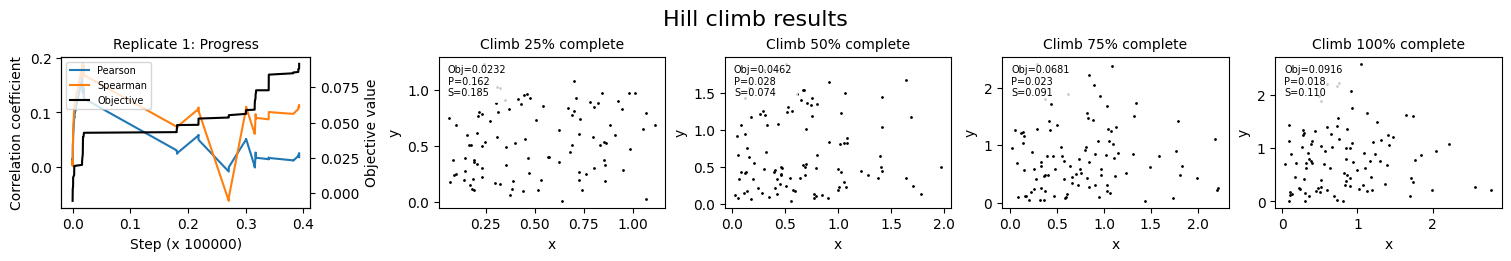

In [8]:
# Create figure with subplots (each row is a replicate, 5 columns: progress + 4 snapshots)
n_replicates = len(results)
n_cols = 5  # Progress plot + 4 distribution snapshots

fig = plt.figure(constrained_layout=True, figsize=(3*n_cols, 2.5*n_replicates))
widths = [1.1, 1, 1, 1, 1]
heights = [1] * n_replicates
spec = fig.add_gridspec(nrows=n_replicates, ncols=n_cols, width_ratios=widths, height_ratios=heights)

fig.suptitle('Hill climb results', fontsize=16)

# Process each replicate
for i in range(n_replicates):
    
    # Get results for this replicate
    best_x, best_y, steps_df = results[i]
    
    # Column 0: Hill climb progress
    ax = fig.add_subplot(spec[i, 0])

    ax.set_title(f'Replicate {i+1}: Progress', fontsize=10)
    
    # Left y-axis: Pearson and Spearman coefficients
    line1 = ax.plot(
        steps_df['Step'] / 100000,
        steps_df['Pearson coefficient'], 
        label='Pearson'
    )

    line2 = ax.plot(
        steps_df['Step'] / 100000,
        steps_df['Spearman coefficient'], 
        label='Spearman'
    )

    ax.set_xlabel('Step (x 100000)')
    ax.set_ylabel('Correlation coefficient', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    
    # Right y-axis: Objective value
    ax2 = ax.twinx()

    line3 = ax2.plot(
        steps_df['Step'] / 100000,
        steps_df['Objective value'], 
        label='Objective',
        color='black'
    )

    ax2.set_ylabel('Objective value', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Set single legend for both axes
    lines = line1 + line2 + line3
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc='best', fontsize=7)
    
    # Columns 1-4: Distribution snapshots at 25%, 50%, 75%, 100%
    total_steps = len(steps_df)
    snapshot_percentages = [0.25, 0.50, 0.75, 1.0]
    snapshot_labels = ['25%', '50%', '75%', '100%']
    
    for j, (pct, label) in enumerate(zip(snapshot_percentages, snapshot_labels)):
        ax = fig.add_subplot(spec[i, j+1])
        
        # Get the index for this percentage of steps
        step_idx = min(int(total_steps * pct) - 1, total_steps - 1)
        step_idx = max(0, step_idx)  # Ensure non-negative
        
        # Get the vectors at this step
        snapshot_x = steps_df['Best_x'].iloc[step_idx]
        snapshot_y = steps_df['Best_y'].iloc[step_idx]
        
        # Plot the distribution at this snapshot
        ax.set_title(f'Climb {label} complete', fontsize=10)
        ax.scatter(snapshot_x, snapshot_y, color='black', s=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Get the objective value at this step
        obj_val = steps_df['Objective value'].iloc[step_idx]
        pearson_val = steps_df['Pearson coefficient'].iloc[step_idx]
        spearman_val = steps_df['Spearman coefficient'].iloc[step_idx]
        
        ax.text(
            0.04, 0.95,
            f'Obj={obj_val:.4f}\nP={pearson_val:.3f}\nS={spearman_val:.3f}', 
            transform=ax.transAxes,
            fontsize=7,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
        )

plt.show()

## 2. Solutions

In [9]:
def load_hill_climb_results(filename):
    '''Load and inspect saved hill climbing results.
    
    Args:
        filename: Path to the pickle file containing results
        
    Returns:
        Dictionary containing results, hyperparameters, and metadata
    '''
    with open(filename, 'rb') as f:
        results_package = pickle.load(f)
    
    print(f"Loaded results from: {filename}")
    print(f"Objective function: {results_package['hyperparameters']['objective_function']}")
    print(f"Runtime: {results_package['runtime_minutes']:.2f} minutes")
    print(f"Hyperparameters:")
    for key, value in results_package['hyperparameters'].items():
        if key != 'objective_function':
            print(f"  {key}: {value}")
    
    return results_package

In [10]:
def plot_solution(df, title):
    '''Plot solution data with correlation statistics and distributions.
    
    Args:
        df: DataFrame with 'x' and 'y' columns containing the solution data
        title: String for the plot title
    '''
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    
    fig.suptitle(title, fontsize=14)
    
    # Calculate correlation coefficients
    pearson_corr = df['x'].corr(df['y'], method='pearson')
    spearman_corr = df['x'].corr(df['y'], method='spearman')
    corr_diff = abs(spearman_corr - pearson_corr)
    
    # Calculate linear regression
    coeffs = np.polyfit(df['x'], df['y'], 1)
    poly = np.poly1d(coeffs)
    x_line = np.linspace(df['x'].min(), df['x'].max(), 100)
    y_line = poly(x_line)
    
    # Left plot: Scatter plot with regression line and statistics
    axs[0].set_title('Vectors')
    axs[0].scatter(df['x'], df['y'], color='black', s=1)
    axs[0].plot(x_line, y_line, 'r-', linewidth=2, label='Linear Regression')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    # Add correlation statistics
    stats_text = f'Pearson: {pearson_corr:.4f}\n'
    stats_text += f'Spearman: {spearman_corr:.4f}\n'
    stats_text += f'Difference: {corr_diff:.4f}'
    
    axs[0].text(0.02, 0.98, stats_text, transform=axs[0].transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(facecolor='lightgrey', alpha=0.8))
    
    # Middle plot: x distribution
    axs[1].set_title('x distribution')
    axs[1].hist(df['x'], bins=30, color='gray', edgecolor='black')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Count')
    
    # Right plot: y distribution
    axs[2].set_title('y distribution')
    axs[2].hist(df['y'], bins=30, color='gray', edgecolor='black')
    axs[2].set_xlabel('y')
    axs[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()